# Galaxy Clusters & Velocity Appendix: Peaks in the Halo mass distribution

Author: Julien Peloton [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2018-12-28  
Estimated running time: < 5 min.

This notebook, with the help of Apache Spark, inspects the peaks found in the halo mass distribution in the companion notebook.

**Summary:**

If we look at the distribution of halo masses in cosmoDC2, all seem OK. But if we look at the same distribution after filtering objects according to the stellar mass, we start to see peaks in the distribution. These peaks are regularly spaced in log, and their position is independent on the stellar mass cut applied.


**Logistics:** 

This notebook is intended to be run through the JupyterHub NERSC interface with the desc-pyspark kernel. The kernel is automatically installed in your environment when you use the kernel setup script:

```bash
source /global/common/software/lsst/common/miniconda/kernels/setup.sh
```

In [1]:
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Path to the data
fn = "/global/cscratch1/sd/peloton/cosmodc2/xyz_v1.1.4_mass.parquet"

# Load the data - this a lazy operation, no data movement yet!
df = spark.read.format("parquet").load(fn)

# Let's inspect the schema
df.printSchema()

# Number of objects in the catalog
print("Number of rows: {}".format(df.count()))

root
 |-- velocity_y: float (nullable = true)
 |-- diskMassStellar: float (nullable = true)
 |-- stellar_mass_bulge: float (nullable = true)
 |-- position_z: float (nullable = true)
 |-- stellar_mass_disk: float (nullable = true)
 |-- halo_mass: float (nullable = true)
 |-- spheroidMassStellar: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- baseDC2/target_halo_mass: float (nullable = true)
 |-- stellar_mass: float (nullable = true)
 |-- ra: float (nullable = true)
 |-- is_central: boolean (nullable = true)
 |-- blackHoleMass: float (nullable = true)
 |-- velocity_z: float (nullable = true)
 |-- velocity_x: float (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- hostHaloMass: float (nullable = true)
 |-- redshift: float (nullable = true)
 |-- totalMassStellar: float (nullable = true)
 |-- position_x: float (nullable = true)
 |-- position_y: float (nullable = true)

Number of rows: 292781506


## Data preparation: selecting massive halos


In [3]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
# In addition we select halo members according to their stellar mass
stellar_masses_cut = [1e9, 1e10, 5e10, 1e11]
full_data = []
for stellar_mass_cut in stellar_masses_cut:
    df_filt = df.filter("halo_id > 0").filter("stellar_mass > {}".format(stellar_mass_cut))

    # Group data by halos and compute the number of halo members
    df_disp = df_filt.groupBy("halo_id").count()

    # Add back the original DataFrame columns
    # and select only central member for halo 
    # (unique halo mass for a halo)
    data_joined = df_filt.join(df_disp, "halo_id")\
        .filter("is_central == True")\
        .select("halo_mass", 'count')\
        .dropna()

    # Collect the data from the executors to the driver
    data = data_joined.collect()
    full_data.append(data)

## Halo mass distribution

(for the version without cut, see the main notebook)

Number of entries ($M_*$ > 1.0e+09 $M_\odot$): 6932086
Number of entries ($M_*$ > 1.0e+10 $M_\odot$): 1800258
Number of entries ($M_*$ > 5.0e+10 $M_\odot$): 458409
Number of entries ($M_*$ > 1.0e+11 $M_\odot$): 160443


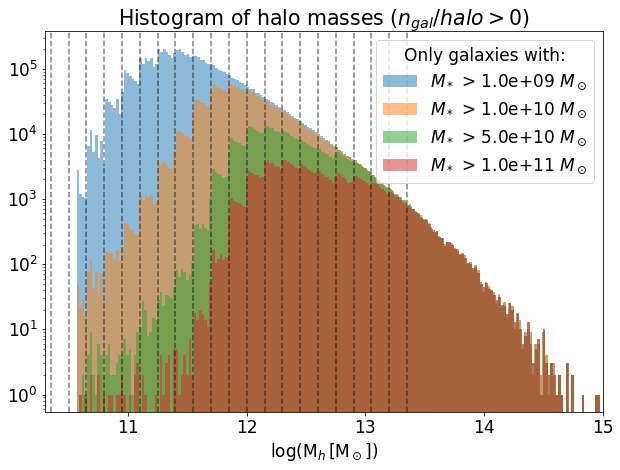

In [6]:
matplotlib.rcParams.update({'font.size': 17})

fig = plt.figure(figsize=(10, 7))
plt.title("Histogram of halo masses ($n_{{gal}}/halo > 0$)")

# Plot peak locations (empirical!)
for k in range(90):
    plt.axvline(k*0.15, ls='--', color='k', alpha=0.5)

# Plot halo mass data
for index, stellar_mass_cut in enumerate(stellar_masses_cut):
    mass, count = np.transpose(full_data[index])
    print(r"Number of entries ($M_*$ > {:.1e} $M_\odot$): {}".format(stellar_mass_cut, len(mass)))
    plt.hist(np.log10(mass), bins=200, alpha=0.5, label='$M_*$ > {:.1e} $M_\odot$'.format(stellar_mass_cut))
    

plt.xlim(10.3, 15)
plt.xlabel(r'$\log({\rm M}_h \, [{\rm M}_\odot])$')
plt.yscale('log')
plt.legend(title="Only galaxies with:")
plt.show()

The position $p$ of the peaks is independent of the cut on the stellar mass, and it seems to follow:

$$ \log(M_{h}^{p}) = 0.15 * p $$


Let's plot the same distribution, but selecting only halos with at least 2 members

Number of entries ($M_*$ > 1.0e+09 $M_\odot$): 1074787
Number of entries ($M_*$ > 1.0e+10 $M_\odot$): 270393
Number of entries ($M_*$ > 5.0e+10 $M_\odot$): 54701
Number of entries ($M_*$ > 1.0e+11 $M_\odot$): 15093


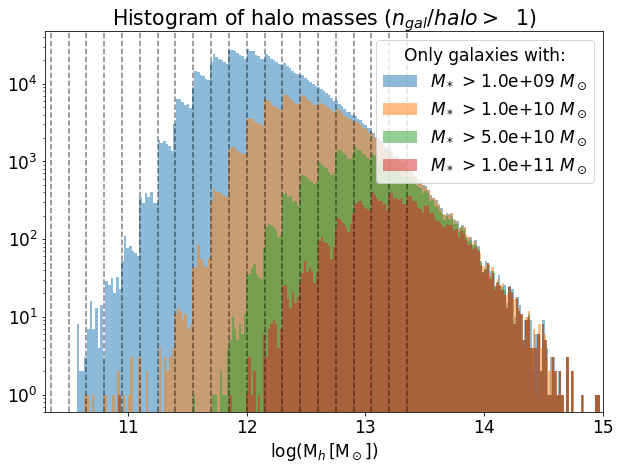

In [7]:
matplotlib.rcParams.update({'font.size': 17})

mincount = 1

fig = plt.figure(figsize=(10, 7))
plt.title("Histogram of halo masses ($n_{{gal}}/halo >$  {})".format(mincount))

# Plot peak locations (empirical!)
for k in range(90):
    plt.axvline(k*0.15, ls='--', color='k', alpha=0.5)

# Plot halo mass data
for index, stellar_mass_cut in enumerate(stellar_masses_cut):
    mass, count = np.transpose(full_data[index])
    mask = count > mincount
    print(r"Number of entries ($M_*$ > {:.1e} $M_\odot$): {}".format(stellar_mass_cut, len(mass[mask])))
    plt.hist(np.log10(mass[mask]), bins=200, alpha=0.5, label='$M_*$ > {:.1e} $M_\odot$'.format(stellar_mass_cut))
    

plt.xlim(10.3, 15)
plt.xlabel(r'$\log({\rm M}_h \, [{\rm M}_\odot])$')
plt.yscale('log')
plt.legend(title="Only galaxies with:")
plt.show()

Same conclusions

**Question:** Is that expected?